In [1]:
!pip install --quiet tensorflow-text
!pip install --quiet tokenizers

In [2]:
import os 
import json
# from google.colab import files 
from google.colab import drive
drive.mount('/content/drive')
import pandas as pd
import numpy as np
import re

import matplotlib.pyplot as plt 
# import tensorflow as tf 
# from tensorflow import keras
# from tensorflow.keras import layers,Input,Model
# from tensorflow.keras.layers import * 
# from tensorflow.keras.preprocessing.sequence import pad_sequences

import tensorflow_hub as hub 
from tokenizers import BertWordPieceTokenizer
# import tensorflow.compat.v1 as tf
import tensorflow_text as text 

bert_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2", trainable=True)
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy().decode("utf-8")
tokenizer = BertWordPieceTokenizer(vocab=vocab_file, lowercase=True)
plt.style.use('ggplot')
import seaborn as sns

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
from data_loader import df_maker,answer_extractor
input_len = 384

In [4]:
train_path = 'drive/MyDrive/Colab Notebooks/datasets/squad/train-v1.1.json'
test_path = 'drive/MyDrive/Colab Notebooks/datasets/squad/dev-v1.1.json'

train_data = df_maker(train_path).squad_json_to_dataframe()
test_data = df_maker(test_path).squad_json_to_dataframe()

In [5]:
train_answer_text,train_answer_pos = answer_extractor(train_data['answers']).answer_extractor_2()
test_answer_text,test_answer_pos = answer_extractor(test_data['answers']).answer_extractor_2()

train_data = train_data.drop(columns = ['id', 'c_id'])
train_data['answers'] = train_answer_text
train_data['starting_idx'] = train_answer_pos

test_data = test_data.drop(columns = ['id', 'c_id'])
test_data['answers'] = test_answer_text
test_data['starting_idx'] = test_answer_pos
train_data = train_data.reset_index(drop=True)
test_data = test_data.reset_index(drop=True)

class str_maker :

  def __init__(self, data):
    self.data = data 

  def splitter(self):
    bos = []
    for i in self.data:
      bos.append(' '.join(i.split()))

    return bos

train_answer_str = str_maker(train_data['answers']).splitter()
train_question_str = str_maker(train_data['question']).splitter()
train_context_str = str_maker(train_data['context']).splitter()

test_answer_str = str_maker(test_data['answers']).splitter()
test_question_str = str_maker(test_data['question']).splitter()
test_context_str = str_maker(test_data['context']).splitter()


def token_positioner(x):
    first_pos = []
    last_pos = []
    for i in range(len(x)):
        context_ids = tokenizer.encode(x['context'][i]).ids
        answer_ids = tokenizer.encode(x['answers'][i]).ids[1:-1]
        pos = (np.where(np.in1d(context_ids,answer_ids)== True)[0])

        if len(pos) != 0 :
            first_pos.append(pos[0])
            last_pos.append(pos[0]+len(answer_ids))

        else :
            first_pos.append(-1)
            last_pos.append(-1)


    return first_pos, last_pos

first_pos_train,last_pos_train = token_positioner(train_data)
first_pos_test,last_pos_test = token_positioner(test_data)

dropper = np.where(np.array(first_pos_train) == -1)[0]
dropper2 = np.where(np.array(last_pos_train) > input_len-1)[0]
train_data  = train_data.drop(dropper)
train_data  = train_data.drop(dropper2).reset_index(drop = True)

train_answer_str = str_maker(train_data['answers']).splitter()
train_question_str = str_maker(train_data['question']).splitter()
train_context_str = str_maker(train_data['context']).splitter()

test_answer_str = str_maker(test_data['answers']).splitter()
test_question_str = str_maker(test_data['question']).splitter()
test_context_str = str_maker(test_data['context']).splitter()

first_pos_train,last_pos_train = token_positioner(train_data)
first_pos_test,last_pos_test = token_positioner(test_data)

train_data['first_pos'] = first_pos_train
train_data['last_pos'] = last_pos_train

test_data['first_pos'] = first_pos_test
test_data['last_pos'] = last_pos_test

In [6]:
print('number of train data point',len(train_data))
print(train_data.dtypes)

print('number of test data point',len(test_data))
print(test_data.dtypes)

number of train data point 87454
question        object
context         object
answers         object
starting_idx     int64
first_pos        int64
last_pos         int64
dtype: object
number of test data point 10570
question        object
context         object
answers         object
starting_idx     int64
first_pos        int64
last_pos         int64
dtype: object


In [7]:
train_data.head(3)

,question,context,answers,starting_idx,first_pos,last_pos
0,To whom did the Virgin Mary allegedly appear i...,"Architecturally, the school has a Catholic cha...",Saint Bernadette Soubirous,515,114,122
1,What is in front of the Notre Dame Main Building?,"Architecturally, the school has a Catholic cha...",a copper statue of Christ,188,7,12
2,The Basilica of the Sacred heart at Notre Dame...,"Architecturally, the school has a Catholic cha...",the Main Building,279,4,7


In [8]:
train_data.head(3)

,question,context,answers,starting_idx,first_pos,last_pos
0,To whom did the Virgin Mary allegedly appear i...,"Architecturally, the school has a Catholic cha...",Saint Bernadette Soubirous,515,114,122
1,What is in front of the Notre Dame Main Building?,"Architecturally, the school has a Catholic cha...",a copper statue of Christ,188,7,12
2,The Basilica of the Sacred heart at Notre Dame...,"Architecturally, the school has a Catholic cha...",the Main Building,279,4,7


In [9]:
def string_len(x):
    str_len = []
    for i in range(len(x)):
        str_len.append(len(str(x[i]).split()))

    return str_len

In [10]:
train_q_len = string_len(train_data['question'])
train_c_len = string_len(train_data['context'])
train_a_len = string_len(train_data['answers'])

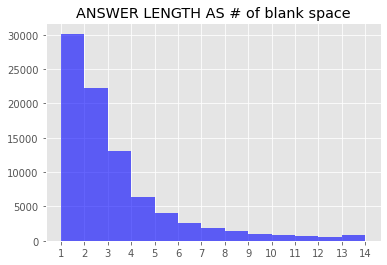

In [22]:
plt.hist(train_a_len,  bins=np.arange(1,15), color='blue', alpha = 0.6);
plt.title('ANSWER LENGTH AS # of blank space');
plt.xticks(np.arange(1,15));

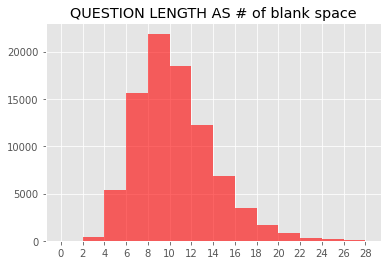

In [23]:
plt.hist(train_q_len,  bins=np.arange(0,30,2), color='red', alpha = 0.6);
plt.title('QUESTION LENGTH AS # of blank space');
plt.xticks(np.arange(0,30,2));

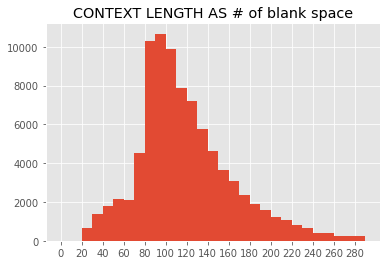

In [24]:
plt.hist(train_c_len,  bins=np.arange(0,300,10));
plt.title('CONTEXT LENGTH AS # of blank space');
plt.xticks(np.arange(0,300,20));

In [14]:
### As tokenizer BERT tokenizer will be used
### Bert tokenizer has limited predefined corpus size
### Therefore, some out of vocabulary words will be tokenized using word piece tokenization 


In [15]:
def encoder(x):
    tokenizer = BertWordPieceTokenizer(vocab=vocab_file, lowercase=True)
    ids = []
    type_ids = []
    # tokens = []
    # offsets = []
    attention_mask = []
    # special_tokens_mask =[]
    ids_len = []
    for i in range(len(x)):
        var1 = tokenizer.encode(x[i])
        ids.append(var1.ids)
        type_ids.append(var1.type_ids)
        # tokens.append(var1.tokens)
        # offsets.append(var1.offsets)
        attention_mask.append(var1.attention_mask)
        # special_tokens_mask.append(var1.special_tokens_mask)
        ids_len.append(len(var1.ids))
    return ids, type_ids, attention_mask,ids_len

cont_ids, cont_type_ids, cont_attention_mask, cont_ids_len = encoder(train_context_str)
ans_ids, ans_type_ids , ans_attention_mask,  ans_ids_len = encoder(train_answer_str)
qeust_ids, quest_type_ids , quest_attention_mask,  quest_ids_len = encoder(test_question_str)


In [16]:
len(quest_ids_len)

10570

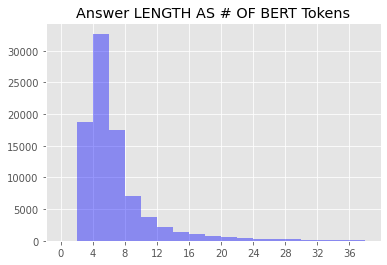

In [17]:
plt.hist(ans_ids_len, 
         bins=np.arange(0,40,2), color='blue', alpha = 0.4
         );
plt.title('Answer LENGTH AS # OF BERT Tokens');
plt.xticks(np.arange(0,40,4));

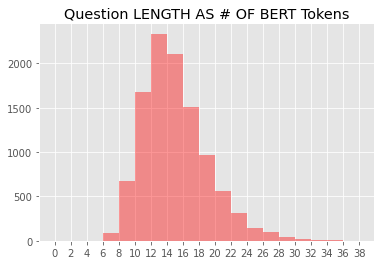

In [18]:
plt.hist(quest_ids_len, 
         bins=np.arange(0,40,2), color='red', alpha = 0.4
         );
plt.title('Question LENGTH AS # OF BERT Tokens');
plt.xticks(np.arange(0,40,2));

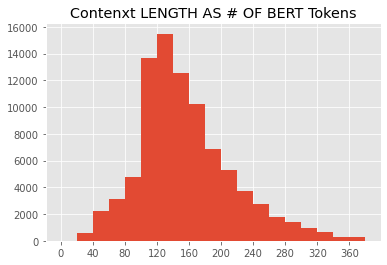

In [19]:
plt.hist(cont_ids_len, bins=np.arange(0,400,20));
plt.title('Contenxt LENGTH AS # OF BERT Tokens');
plt.xticks(np.arange(0,400,40));

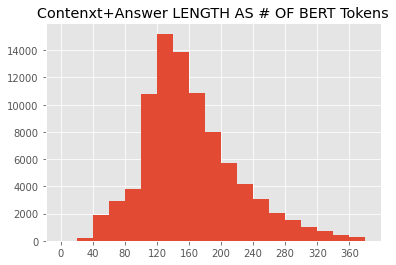

In [20]:
plt.hist(np.add(cont_ids_len,ans_ids_len), bins=np.arange(0,400,20));
plt.title('Contenxt+Answer LENGTH AS # OF BERT Tokens');
plt.xticks(np.arange(0,400,40));

In [21]:
## BERT models have variable input lenths such as 128, 256,384, and 512
## As seen from the tokenized answer and and context length it is suitable to use max input length as 384
